In [33]:
from PIL import Image, ImageDraw, ImageSequence
import io
import matplotlib.pyplot as plt
import glob, os
import numpy as np
import contextlib

In [7]:
fp_in = "saved_images/epoch_*/pred_0.png"
fp_out = "pred_0.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=500, loop=0)

In [51]:
def split_images(images, n=8):
    images = images[2:-2,:,:]
    image_list = []
    for i in range(n):
        starty = 2+(i)*258
        endy = starty+256
        image_list.append(images[:,starty:endy,:])
    
    return image_list


def all_split(image_paths):
    all_images = []
    for impath in image_paths:
        img = np.array(Image.open(impath).convert("RGB"))
        n = int((img.shape[1]-2)/258)
        all_images.extend(split_images(img, n=n))
    return all_images


def accuracy_for_p(y, yhat):
    comp = yhat == y
    acc = (comp[:,:,0] & comp[:,:,1] & comp[:,:,2]).mean()
    return acc

def generate_gif(images, filename):
    image_paths = sorted(glob.glob(images))
    imagelist = []
    for impath in image_paths:
        im = Image.open(impath)
        imagelist.append(im)
    
    imagelist[0].save(fp=filename, format="GIF", append_images=imagelist[1:], duration=500, loop=0, save_all=True)
    
    frames = []
    for frame, impath in zip(ImageSequence.Iterator(Image.open(filename)), image_paths):
        label = "Epoch " + impath.split(os.sep)[-2].split('_')[-1]
        d = ImageDraw.Draw(frame)
        d.text((10,100), label, fill=(0, 0, 0))
        del d
        b = io.BytesIO()
        frame.save(b, format="GIF")
        frame = Image.open(b)
        
        frames.append(frame)
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=500, loop=0)


def numpytogif(listofimages, filename):
    listofimages = [Image.fromarray(img, mode="RGB") for img in listofimages]
    listofimages[0].save(fp=filename, format="GIF", append_images=listofimages[1:], duration=500, loop=0, save_all=True)

generate_gif("saved_images/epoch_*/pred_0.png", "pred_0_all.gif")     

In [52]:
pred_images = sorted(glob.glob(os.path.join("saved_images", "epoch_40", "pred_*.png")))
gt_images = glob.glob(os.path.join("saved_images", "epoch_40", "*.png"))
gt_images = sorted(list(set(gt_images) - set(pred_images)))

preds = all_split(pred_images)
gts = all_split(gt_images)

In [53]:
numpytogif(all_split(sorted(glob.glob(os.path.join("saved_images", "epoch_*", "pred_0.png")))), "test.gif")

In [55]:
img1all = all_split(sorted(glob.glob(os.path.join("saved_images", "epoch_*", "pred_0.png"))))[::8]

In [57]:
len(img1all)

6

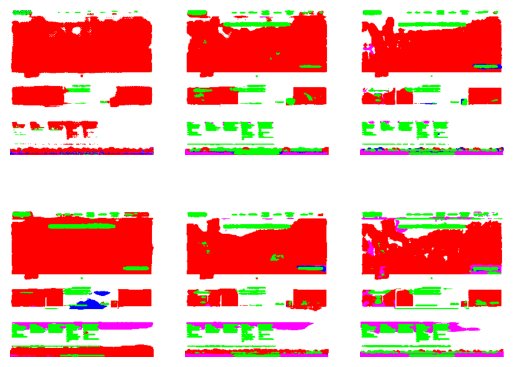

In [62]:
def plot_multiple(images): 
    from matplotlib import gridspec
    fig = plt.figure()
    grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

    subfig00 = fig.add_subplot(grid[0, 0])
    subfig01 = fig.add_subplot(grid[0, 1])
    subfig02 = fig.add_subplot(grid[0, 2])
    subfig10 = fig.add_subplot(grid[1, 0])
    subfig11 = fig.add_subplot(grid[1, 1])
    subfig12 = fig.add_subplot(grid[1, 2])
    
    subfigures = fig.get_axes()

    for i, subfig in enumerate(subfigures, start=1):
        subfig.spines['top'].set_visible(False)
        subfig.spines['right'].set_visible(False)
        subfig.axis('off')
        
    subfig00.imshow(images[0])
    subfig01.imshow(images[1])
    subfig02.imshow(images[2])
    subfig10.imshow(images[3])
    subfig11.imshow(images[4])
    subfig12.imshow(images[5])
    
    plt.axis('off')
    plt.show()

plot_multiple(img1all)

In [80]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def split_each_image(gtpath, predpath, filename="animated_"):
    # path will be os.path.join("saved_images", "epoch_*", "pred_n.png")
    all_pred_images = all_split(sorted(glob.glob(predpath)))
    all_gt_images = all_split(sorted(glob.glob(gtpath)))
    
    N = len(all_pred_images)
    num_images = N // 6
    
    for i in range(0, num_images):
        temp_pred = all_pred_images[i::num_images]
        temp_gt = all_gt_images[i::num_images]
        # print(f"Len preds: {len(temp_pred)} - Len gtruths: {len(temp_gt)}")
        
        # assert len(temp_pred) != 6
        # assert len(temp_gt) != 6
        
        """
        from matplotlib import gridspec
        fig = plt.figure()
        grid = gridspec.GridSpec(ncols=6, nrows=2, figure=fig)
        
        for idx, (pred, gt) in enumerate(zip(temp_pred, temp_gt)):
            sf0 = fig.add_subplot(grid[0, idx])
            sf1 = fig.add_subplot(grid[1, idx])
            
            sf0.imshow(pred)
            sf1.imshow(gt)
        
        subfigures = fig.get_axes()

        for _, subfig in enumerate(subfigures, start=1):
            subfig.spines['top'].set_visible(False)
            subfig.spines['right'].set_visible(False)
            subfig.axis('off')
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        """
        
        imagelist = [get_concat_h(Image.fromarray(imgt), Image.fromarray(impr)) for imgt, impr in zip(temp_gt, temp_pred)]
        imagelist[0].save(fp=filename+f"{i}.gif", format="GIF", append_images=imagelist[1:], duration=500, loop=0, save_all=True)
        
        frames = []
        for epoch, frame in zip([1, 10, 20, 30, 40, 50], ImageSequence.Iterator(Image.open(filename+f"{i}.gif"))):
            label = f"Epoch {epoch}" # + impath.split(os.sep)[-2].split('_')[-1]
            d = ImageDraw.Draw(frame)
            d.text((10,100), label, fill=(0, 0, 0))
            del d
            b = io.BytesIO()
            frame.save(b, format="GIF")
            frame = Image.open(b)
            
            frames.append(frame)
        frames[0].save(filename+f"{i}.gif", save_all=True, append_images=frames[1:], duration=1000, loop=0)
        
        

for n in range(0, 12):
    split_each_image(
        os.path.join("saved_images", "epoch_*", f"pred_{n}.png"),
        os.path.join("saved_images", "epoch_*", f"{n}.png"),
        filename=f"{n}_animated_"
        )

In [53]:
accs = []
for gt, pred in zip(gts, preds):
    accs.append(accuracy_for_p(gt, pred))

accs = np.array(accs)
print(accs.mean())

0.8202604505750868


In [54]:
accs

array([0.77685547, 0.88337708, 0.78767395, 0.90052795, 0.9818573 ,
       0.91471863, 0.93881226, 0.81648254, 0.87614441, 0.85603333,
       0.91134644, 0.76498413, 0.93081665, 0.89822388, 0.82104492,
       0.82701111, 0.96394348, 0.52352905, 0.78971863, 0.04722595,
       0.94396973, 0.78500366, 0.19407654, 0.84065247, 0.91627502,
       0.68612671, 0.83174133, 0.61819458, 0.89175415, 0.88725281,
       0.65437317, 0.90888977, 0.93409729, 0.63575745, 0.92076111,
       0.94294739, 0.88912964, 0.73901367, 0.90948486, 0.85832214,
       0.83044434, 0.84742737, 0.83543396, 0.78100586, 0.78683472,
       0.8293457 , 0.90010071, 0.80360413, 0.93034363, 0.84356689,
       0.92591858, 0.71707153, 0.79998779, 0.722229  , 0.88633728,
       0.78988647, 0.91923523, 0.60774231, 0.76304626, 0.93823242,
       0.94332886, 0.8157959 , 0.779953  , 0.88899231, 0.84916687,
       0.89002991, 0.93682861, 0.8853302 , 0.75994873, 0.87228394,
       0.95994568, 0.9044342 , 0.85762024, 0.87799072, 0.94612

In [55]:
accs

array([0.77685547, 0.88337708, 0.78767395, 0.90052795, 0.9818573 ,
       0.91471863, 0.93881226, 0.81648254, 0.87614441, 0.85603333,
       0.91134644, 0.76498413, 0.93081665, 0.89822388, 0.82104492,
       0.82701111, 0.96394348, 0.52352905, 0.78971863, 0.04722595,
       0.94396973, 0.78500366, 0.19407654, 0.84065247, 0.91627502,
       0.68612671, 0.83174133, 0.61819458, 0.89175415, 0.88725281,
       0.65437317, 0.90888977, 0.93409729, 0.63575745, 0.92076111,
       0.94294739, 0.88912964, 0.73901367, 0.90948486, 0.85832214,
       0.83044434, 0.84742737, 0.83543396, 0.78100586, 0.78683472,
       0.8293457 , 0.90010071, 0.80360413, 0.93034363, 0.84356689,
       0.92591858, 0.71707153, 0.79998779, 0.722229  , 0.88633728,
       0.78988647, 0.91923523, 0.60774231, 0.76304626, 0.93823242,
       0.94332886, 0.8157959 , 0.779953  , 0.88899231, 0.84916687,
       0.89002991, 0.93682861, 0.8853302 , 0.75994873, 0.87228394,
       0.95994568, 0.9044342 , 0.85762024, 0.87799072, 0.94612

In [13]:
(gt == pred).shape

(256, 256, 3)

In [5]:
accs.mean()

0.913204503942419

In [6]:
from utils import pixel_accuracy, rgb_to_mask
import torch
import pandas as pd
data = pd.read_csv("data/segdict.csv")

In [7]:
accs

array([0.89834086, 0.94286092, 0.88623556, 0.95004272, 0.98790487,
       0.94744364, 0.96389262, 0.895696  , 0.93674215, 0.93464152,
       0.95030212, 0.89068095, 0.95746867, 0.94411214, 0.90298462,
       0.91286214, 0.97855632, 0.72961934, 0.91150411, 0.52756246,
       0.96941121, 0.90065002, 0.70499674, 0.93826803, 0.94847616,
       0.88348389, 0.92212423, 0.85667928, 0.9519755 , 0.9450175 ,
       0.85783895, 0.94157918, 0.95899963, 0.85938517, 0.96034241,
       0.97018941, 0.92931112, 0.90207418, 0.94510905, 0.92353821,
       0.92966207, 0.92047628, 0.91885376, 0.8912557 , 0.90100606,
       0.93422445, 0.94292704, 0.89274597, 0.96605937, 0.91220601,
       0.96218872, 0.87451681, 0.91796366, 0.86373901, 0.94462077,
       0.91384888, 0.9530894 , 0.83187358, 0.89499919, 0.97031657,
       0.96605937, 0.90736389, 0.89914958, 0.93677775, 0.91563416,
       0.92532857, 0.96537781, 0.94207255, 0.89674886, 0.9353536 ,
       0.9750061 , 0.94658915, 0.93378194, 0.93826294, 0.96755

In [8]:
yp = torch.Tensor(rgb_to_mask(preds[0], data).transpose([2, 0, 1])).unsqueeze(0)
yt = torch.Tensor(rgb_to_mask(gts[0], data).transpose([2, 0, 1])).unsqueeze(0)


In [11]:
pixel_accuracy(yt, yp)

0.77685546875

In [10]:
(yp == yt).numpy().mean()

0.9107421875